<a href="https://colab.research.google.com/github/DanielFBottega/chords-identifier-TCC/blob/main/Espectrograma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa matplotlib numpy scipy --quiet

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from google.colab import files

Upload do arquivo de audio

In [ ]:
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]

Saving A7 Chord.mp3 to A7 Chord.mp3


In [ ]:
y, sr = librosa.load(audio_path, sr=None, mono=True)

print(f"Sample rate: {sr}")
print(f"Número de amostras: {len(y)}")
print(f"Duração: {len(y)/sr:.2f} segundos")

Sample rate: 44100
Número de amostras: 126288
Duração: 2.86 segundos


In [ ]:
#Aplicar CQT (Transformada Q-Constante)
C = np.abs(librosa.cqt(y, sr=sr, hop_length=512, bins_per_octave=88, n_bins=88))  # 8 oitavas
frequencies = librosa.cqt_frequencies(n_bins=88, fmin=librosa.note_to_hz('C1'))

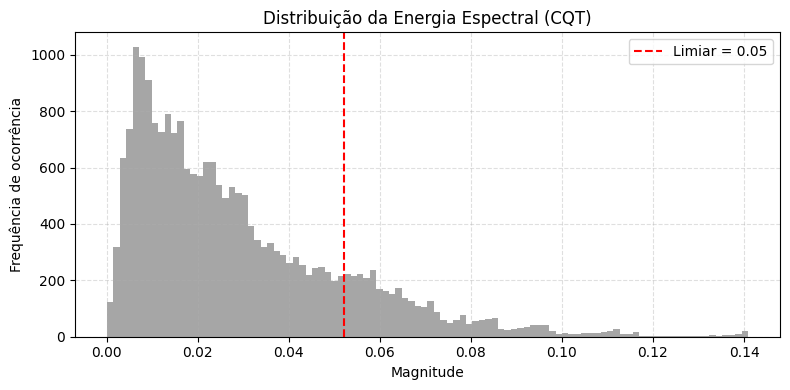

In [ ]:
#Etapa A: Limiar adaptativo
mean_energy = np.mean(C)  # Calcula a energia média de todos os coeficientes da CQT (magnitude média do espectro)
threshold = mean_energy * 1.8 # Ajustável

#Plotar histograma da energia com o limiar visual
plt.figure(figsize=(8, 4))
plt.hist(C.flatten(), bins=100, color='gray', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label=f'Limiar = {threshold:.2f}')
plt.title('Distribuição da Energia Espectral (CQT)')
plt.xlabel('Magnitude')
plt.ylabel('Frequência de ocorrência')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Aplicando de fato o Limiar adaptativo para seguir em frente
C_thresh = np.where(C > threshold, C, 0) # Mantém apenas os valores acima do limiar; zera o restante (remove ruídos e baixas energias)

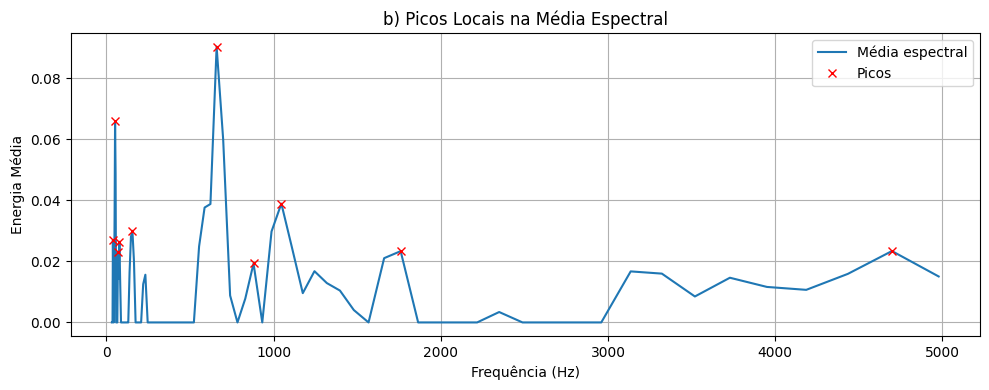

In [ ]:
#Etapa B: Identificação de picos locais na média espectral
mean_spectrum = np.mean(C_thresh, axis=1)
peaks, _ = find_peaks(mean_spectrum, height=np.max(mean_spectrum)*0.2)

plt.figure(figsize=(10, 4))
plt.plot(frequencies, mean_spectrum, label='Média espectral')
plt.plot(frequencies[peaks], mean_spectrum[peaks], 'rx', label='Picos')
plt.title('b) Picos Locais na Média Espectral')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Energia Média')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

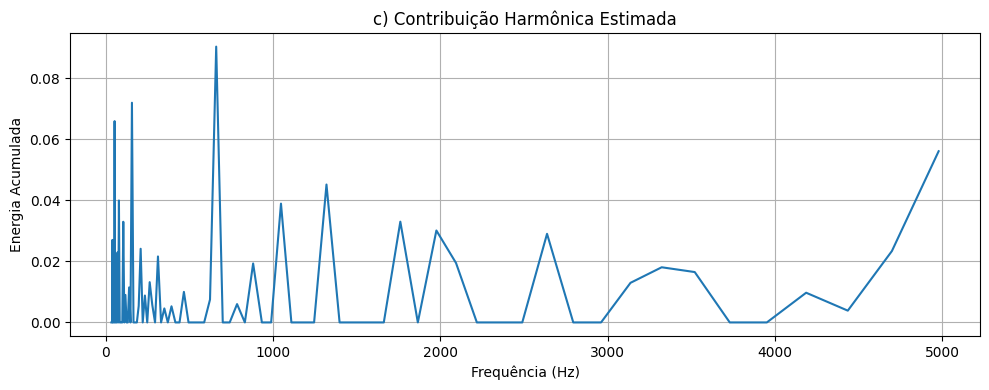

In [ ]:
#Etapa C: Cálculo da contribuição harmônica
harmonic_weights = np.zeros_like(mean_spectrum)
for peak in peaks:
    freq = frequencies[peak]
    for k in range(1, 6):  # considerar até o 5º harmônico
        harmonic_freq = freq * k
        closest_bin = np.argmin(np.abs(frequencies - harmonic_freq))
        harmonic_weights[closest_bin] += mean_spectrum[peak] / k

plt.figure(figsize=(10, 4))
plt.plot(frequencies, harmonic_weights, label='Contribuição Harmônica')
plt.title('c) Contribuição Harmônica Estimada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Energia Acumulada')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=987
  warnings.warn(


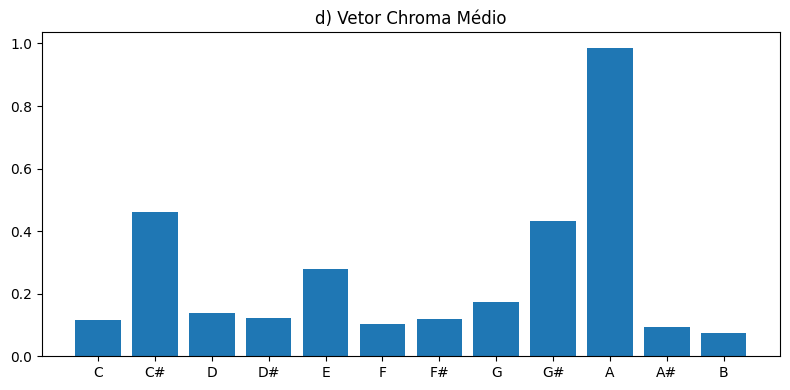

In [ ]:
#Etapa D: Construção do vetor Chroma
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=512)
chroma_mean = np.mean(chroma, axis=1)

plt.figure(figsize=(8, 4))
plt.bar(range(12), chroma_mean)
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F',
                       'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.title('d) Vetor Chroma Médio')
plt.tight_layout()
plt.show()

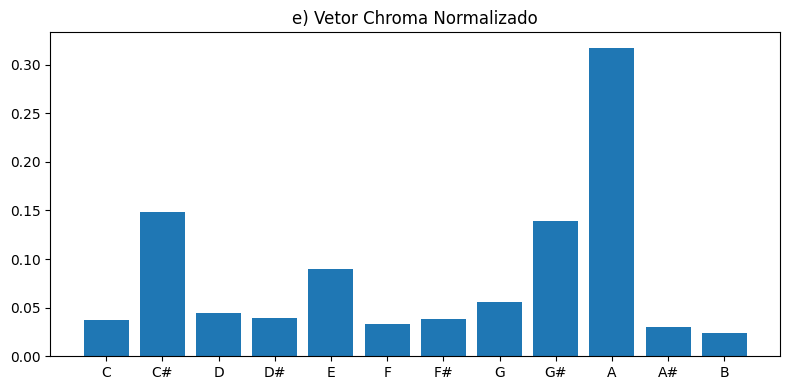

In [ ]:
#Etapa E: Normalização
chroma_norm = chroma_mean / np.sum(chroma_mean)

plt.figure(figsize=(8, 4))
plt.bar(range(12), chroma_norm)
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F',
                       'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.title('e) Vetor Chroma Normalizado')
plt.tight_layout()
plt.show()

In [ ]:
#Etapa F: Identificação das notas predominantes
notas = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
top3 = np.argsort(chroma_norm)[-4:][::-1]
print("f) Notas predominantes detectadas:")
for i in top3:
    print(f"- {notas[i]} (energia normalizada: {chroma_norm[i]:.2f})")


f) Notas predominantes detectadas:
- A (energia normalizada: 0.32)
- C# (energia normalizada: 0.15)
- G# (energia normalizada: 0.14)
- E (energia normalizada: 0.09)
